In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.metrics import classification_report_imbalanced
from sklearn import tree
from sklearn.model_selection import train_test_split
from category_encoders import MEstimateEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Needed for decision tree visualization
import pydotplus
from IPython.display import Image

In [2]:
credit_df=pd.read_csv('../Resources/credit_record.csv', index_col="ID")
application_df=pd.read_csv('../Resources/application_record.csv', index_col="ID")

In [3]:
credit_df.head()

MONTHS_BALANCE STATUS
ID                            
5001711               0      X
5001711              -1      0
5001711              -2      0
5001711              -3      0
5001712               0      C

In [4]:
application_df.head()

CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
ID                                                               
5008804           M            Y               Y             0   
5008805           M            Y               Y             0   
5008806           M            Y               Y             0   
5008808           F            N               Y             0   
5008809           F            N               Y             0   

         AMT_INCOME_TOTAL      NAME_INCOME_TYPE  \
ID                                                
5008804          427500.0               Working   
5008805          427500.0               Working   
5008806          112500.0               Working   
5008808          270000.0  Commercial associate   
5008809          270000.0  Commercial associate   

                   NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
ID                                                             
5008804               Higher education        Civil marriage   
5008805               Higher education        Civil marriage   
5008806  Secondary / secondary special               Married   
5008808  Secondary / secondary special  Single / not married   
5008809  Secondary / secondary special  Single / not married   

         NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  FLAG_MOBIL  \
ID                                                                  
5008804   Rented apartment      -12005          -4542           1   
5008805   Rented apartment      -12005          -4542           1   
5008806  House / apartment      -21474          -1134           1   
5008808  House / apartment      -19110          -3051           1   
5008809  House / apartment      -19110          -3051           1   

         FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
ID                                                                 
5008804                1           0           0             NaN   
5008805                1           0           0             NaN   
5008806                0           0           0  Security staff   
5008808                0           1           1     Sales staff   
5008809                0           1           1     Sales staff   

         CNT_FAM_MEMBERS  
ID                        
5008804              2.0  
5008805              2.0  
5008806              2.0  
5008808              1.0  
5008809              1.0

In [5]:
grouped=credit_df.groupby('ID')['STATUS'].value_counts()
grouped

ID       STATUS
5001711  0          3
         X          1
5001712  0         10
         C          9
5001713  X         22
                   ..
5150483  X         18
5150484  0         12
         C          1
5150485  0          2
5150487  C         30
Name: count, Length: 94143, dtype: int64

In [6]:
credit_grouped=pd.get_dummies(data=credit_df,columns=['STATUS'],
                              prefix='',prefix_sep='').groupby('ID')[sorted(credit_df['STATUS'].unique().tolist())].sum()
credit_grouped=credit_grouped.rename(columns=
                      {'0':'pastdue_1_29',
                       '1':'pastdue_30_59',
                       '2':'pastdue_60_89',
                       '3':'pastdue_90_119',
                       '4':'pastdue_120_149',
                       '5':'pastdue_over_150',
                       'C':'paid_off',
                       'X':'no_loan',
                      })

credit_grouped['number_of_months']=credit_df.groupby('ID')['MONTHS_BALANCE'].count()
credit_grouped

pastdue_1_29  pastdue_30_59  pastdue_60_89  pastdue_90_119  \
ID                                                                    
5001711             3              0              0               0   
5001712            10              0              0               0   
5001713             0              0              0               0   
5001714             0              0              0               0   
5001715             0              0              0               0   
...               ...            ...            ...             ...   
5150482            12              0              0               0   
5150483             0              0              0               0   
5150484            12              0              0               0   
5150485             2              0              0               0   
5150487             0              0              0               0   

         pastdue_120_149  pastdue_over_150  paid_off  no_loan  \
ID                                                              
5001711                0                 0         0        1   
5001712                0                 0         9        0   
5001713                0                 0         0       22   
5001714                0                 0         0       15   
5001715                0                 0         0       60   
...                  ...               ...       ...      ...   
5150482                0                 0         6        0   
5150483                0                 0         0       18   
5150484                0                 0         1        0   
5150485                0                 0         0        0   
5150487                0                 0        30        0   

         number_of_months  
ID                         
5001711                 4  
5001712                19  
5001713                22  
5001714                15  
5001715                60  
...                   ...  
5150482                18  
5150483                18  
5150484                13  
5150485                 2  
5150487                30  

[45985 rows x 9 columns]

In [7]:
credit_grouped['pastdue_60_89'].value_counts()

pastdue_60_89
0    45388
1      435
2      100
3       39
4       12
5        4
6        3
8        2
7        2
Name: count, dtype: int64

In [8]:
credit_grouped['pastdue_30_59'].value_counts()

pastdue_30_59
0     40784
1      2888
2      1110
3       470
4       268
5       143
6        94
7        63
8        53
9        30
10       23
13       17
11       13
12        8
16        6
15        4
14        2
19        2
18        1
31        1
21        1
27        1
38        1
22        1
17        1
Name: count, dtype: int64

In [9]:
credit_grouped['customer_status'] = credit_grouped['pastdue_30_59'].apply(lambda x: 1 if x > 0 else 0)
credit_grouped

pastdue_1_29  pastdue_30_59  pastdue_60_89  pastdue_90_119  \
ID                                                                    
5001711             3              0              0               0   
5001712            10              0              0               0   
5001713             0              0              0               0   
5001714             0              0              0               0   
5001715             0              0              0               0   
...               ...            ...            ...             ...   
5150482            12              0              0               0   
5150483             0              0              0               0   
5150484            12              0              0               0   
5150485             2              0              0               0   
5150487             0              0              0               0   

         pastdue_120_149  pastdue_over_150  paid_off  no_loan  \
ID                                                              
5001711                0                 0         0        1   
5001712                0                 0         9        0   
5001713                0                 0         0       22   
5001714                0                 0         0       15   
5001715                0                 0         0       60   
...                  ...               ...       ...      ...   
5150482                0                 0         6        0   
5150483                0                 0         0       18   
5150484                0                 0         1        0   
5150485                0                 0         0        0   
5150487                0                 0        30        0   

         number_of_months  customer_status  
ID                                          
5001711                 4                0  
5001712                19                0  
5001713                22                0  
5001714                15                0  
5001715                60                0  
...                   ...              ...  
5150482                18                0  
5150483                18                0  
5150484                13                0  
5150485                 2                0  
5150487                30                0  

[45985 rows x 10 columns]

In [10]:
merged_df = pd.merge(credit_grouped[["customer_status"]], application_df, how='inner', left_index=True, right_index=True)

In [11]:
merged_df.head(60)

customer_status CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
ID                                                                  
5008804                1           M            Y               Y   
5008805                1           M            Y               Y   
5008806                0           M            Y               Y   
5008808                0           F            N               Y   
5008809                0           F            N               Y   

         CNT_CHILDREN  AMT_INCOME_TOTAL      NAME_INCOME_TYPE  \
ID                                                              
5008804             0          427500.0               Working   
5008805             0          427500.0               Working   
5008806             0          112500.0               Working   
5008808             0          270000.0  Commercial associate   
5008809             0          270000.0  Commercial associate   

                   NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
ID                                                             
5008804               Higher education        Civil marriage   
5008805               Higher education        Civil marriage   
5008806  Secondary / secondary special               Married   
5008808  Secondary / secondary special  Single / not married   
5008809  Secondary / secondary special  Single / not married   

         NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  FLAG_MOBIL  \
ID                                                                  
5008804   Rented apartment      -12005          -4542           1   
5008805   Rented apartment      -12005          -4542           1   
5008806  House / apartment      -21474          -1134           1   
5008808  House / apartment      -19110          -3051           1   
5008809  House / apartment      -19110          -3051           1   

         FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
ID                                                                 
5008804                1           0           0             NaN   
5008805                1           0           0             NaN   
5008806                0           0           0  Security staff   
5008808                0           1           1     Sales staff   
5008809                0           1           1     Sales staff   

         CNT_FAM_MEMBERS  
ID                        
5008804              2.0  
5008805              2.0  
5008806              2.0  
5008808              1.0  
5008809              1.0

In [12]:
merged_df['AGE'] = round(-merged_df["DAYS_BIRTH"]/365.25)
merged_df.drop(columns=['DAYS_BIRTH'], inplace=True)

In [13]:
merged_df['AGE'].unique()

array([33., 59., 52., 62., 46., 49., 29., 51., 27., 30., 35., 32., 56.,
       43., 44., 34., 55., 47., 42., 37., 28., 61., 57., 45., 54., 40.,
       39., 48., 24., 21., 36., 26., 50., 63., 58., 41., 60., 31., 38.,
       53., 22., 64., 23., 25., 65., 67., 66., 69., 68.])

In [14]:
merged_df['YEARS_EMPLOYED'] = round(-merged_df["DAYS_EMPLOYED"]/365.25)
merged_df.drop(columns=['DAYS_EMPLOYED'], inplace=True)

In [15]:
merged_df['YEARS_EMPLOYED'].unique()

array([   12.,     3.,     8., -1000.,     2.,     4.,     6.,     9.,
          19.,    15.,     5.,    13.,     7.,    17.,    30.,    16.,
          11.,     1.,    10.,    24.,    14.,    25.,     0.,    20.,
          27.,    18.,    21.,    23.,    22.,    28.,    39.,    32.,
          33.,    37.,    26.,    38.,    31.,    29.,    35.,    34.,
          41.,    40.,    36.,    42.,    43.])

In [16]:
#For years employed, negative values mean applicant doesn't work, so we convert negative values to 0 as well
merged_df.loc[(merged_df['YEARS_EMPLOYED'] < 0), 'YEARS_EMPLOYED'] = 0

In [17]:
for column in merged_df.columns:
    value_counts_result = merged_df[column].value_counts()
    print(f"\nValue counts for column '{column}':\n{value_counts_result}")



Value counts for column 'customer_status':
customer_status
0    32308
1     4149
Name: count, dtype: int64

Value counts for column 'CODE_GENDER':
CODE_GENDER
F    24430
M    12027
Name: count, dtype: int64

Value counts for column 'FLAG_OWN_CAR':
FLAG_OWN_CAR
N    22614
Y    13843
Name: count, dtype: int64

Value counts for column 'FLAG_OWN_REALTY':
FLAG_OWN_REALTY
Y    24506
N    11951
Name: count, dtype: int64

Value counts for column 'CNT_CHILDREN':
CNT_CHILDREN
0     25201
1      7492
2      3256
3       419
4        63
5        20
14        3
7         2
19        1
Name: count, dtype: int64

Value counts for column 'AMT_INCOME_TOTAL':
AMT_INCOME_TOTAL
135000.0    4309
180000.0    3097
157500.0    3089
112500.0    2956
225000.0    2926
            ... 
147150.0       1
177750.0       1
134995.5       1
31950.0        1
74061.0        1
Name: count, Length: 265, dtype: int64

Value counts for column 'NAME_INCOME_TYPE':
NAME_INCOME_TYPE
Working                 18819
Commercial ass

In [18]:
merged_df.isnull().sum()

customer_status            0
CODE_GENDER                0
FLAG_OWN_CAR               0
FLAG_OWN_REALTY            0
CNT_CHILDREN               0
AMT_INCOME_TOTAL           0
NAME_INCOME_TYPE           0
NAME_EDUCATION_TYPE        0
NAME_FAMILY_STATUS         0
NAME_HOUSING_TYPE          0
FLAG_MOBIL                 0
FLAG_WORK_PHONE            0
FLAG_PHONE                 0
FLAG_EMAIL                 0
OCCUPATION_TYPE        11323
CNT_FAM_MEMBERS            0
AGE                        0
YEARS_EMPLOYED             0
dtype: int64

In [19]:
merged_df.drop(columns=["FLAG_MOBIL", "FLAG_WORK_PHONE", "FLAG_PHONE", "FLAG_EMAIL"], inplace=True)

In [20]:
merged_df["YEARS_EMPLOYED"].unique()

array([12.,  3.,  8.,  0.,  2.,  4.,  6.,  9., 19., 15.,  5., 13.,  7.,
       17., 30., 16., 11.,  1., 10., 24., 14., 25., 20., 27., 18., 21.,
       23., 22., 28., 39., 32., 33., 37., 26., 38., 31., 29., 35., 34.,
       41., 40., 36., 42., 43.])

In [21]:
merged_df["OCCUPATION_TYPE"].nunique()

18

In [22]:
merged_df.dtypes

customer_status          int64
CODE_GENDER             object
FLAG_OWN_CAR            object
FLAG_OWN_REALTY         object
CNT_CHILDREN             int64
AMT_INCOME_TOTAL       float64
NAME_INCOME_TYPE        object
NAME_EDUCATION_TYPE     object
NAME_FAMILY_STATUS      object
NAME_HOUSING_TYPE       object
OCCUPATION_TYPE         object
CNT_FAM_MEMBERS        float64
AGE                    float64
YEARS_EMPLOYED         float64
dtype: object

In [23]:
occupation_df = merged_df.dropna(subset=["OCCUPATION_TYPE"])

In [24]:
nan_occupation_df = merged_df[merged_df['OCCUPATION_TYPE'].isnull()]

In [25]:
# Separate the rows with and without NaN values in the 'OCCUPATION_TYPE' column
df_nan = merged_df[merged_df['OCCUPATION_TYPE'].isna()]
df_not_nan = merged_df.dropna(subset=['OCCUPATION_TYPE'])

# Encode categorical columns
label_encoder = LabelEncoder()
encoded_labels = {}
for column in df_not_nan.select_dtypes(include=['object']).columns:
    df_not_nan[column] = label_encoder.fit_transform(df_not_nan[column])
    encoded_labels[column] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Identify features (X) and target variable (y)
X = df_not_nan.drop(['OCCUPATION_TYPE'], axis=1)
y = label_encoder.fit_transform(df_not_nan['OCCUPATION_TYPE'])  # Encode target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Evaluate the model on the test set
y_true = y_test  # True labels from the test set
y_pred = rf_classifier.predict(X_test)  # Predicted labels on the test set


# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Print accuracy score
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

/var/folders/9z/mjxxydhd64v1_mckv3vlz0h00000gn/T/ipykernel_32299/3335843248.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_nan[column] = label_encoder.fit_transform(df_not_nan[column])
/var/folders/9z/mjxxydhd64v1_mckv3vlz0h00000gn/T/ipykernel_32299/3335843248.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_nan[column] = label_encoder.fit_transform(df_not_nan[column])
/var/folders/9z/mjxxydhd64v1_mckv3vlz0h00000gn/T/ipykernel_32299/3335843248.py:9: SettingWithCopyWarning: 
A value is 

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       270
           1       0.92      0.92      0.92       118
           2       0.96      0.85      0.90       136
           3       0.93      0.91      0.92       736
           4       0.89      0.92      0.90       431
           5       0.92      0.92      0.92        13
           6       0.93      0.88      0.91       293
           7       1.00      0.90      0.95        10
           8       0.91      0.93      0.92      1219
           9       1.00      0.94      0.97        33
          10       0.91      0.91      0.91       591
          11       0.93      0.95      0.94       243
          12       1.00      0.83      0.91        76
          13       0.93      1.00      0.96        13
          14       0.87      0.92      0.90       671
          15       1.00      0.79      0.88        24
          16       0.92      0.84      0.88       116
    

In [26]:
# Identify rows with NaN values in the target variable
X_nan = df_nan.drop(['OCCUPATION_TYPE'], axis=1)

# Encode categorical columns in the NaN rows
for column in X_nan.select_dtypes(include=['object']).columns:
    # Check if label encoder has seen the label before transforming
    X_nan[column] = X_nan[column].map(lambda x: label_encoder.transform([x])[0] if x in label_encoder.classes_ else -1)

# Predict the missing values
predicted_occupations = rf_classifier.predict(X_nan)

# Reverse label encoding using the mapping dictionary
predicted_occupations_original = [encoded_labels['OCCUPATION_TYPE'].get(label, label) for label in predicted_occupations]

predicted_occupations_original = [key for label in predicted_occupations for key, value in encoded_labels['OCCUPATION_TYPE'].items() if value == label]

# Fill NaN values with predicted values
merged_df.loc[merged_df['OCCUPATION_TYPE'].isna(), 'OCCUPATION_TYPE'] = predicted_occupations_original

/var/folders/9z/mjxxydhd64v1_mckv3vlz0h00000gn/T/ipykernel_32299/1842177641.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  X_nan[column] = X_nan[column].map(lambda x: label_encoder.transform([x])[0] if x in label_encoder.classes_ else -1)


In [27]:
merged_df.head(60)

customer_status CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
ID                                                                  
5008804                1           M            Y               Y   
5008805                1           M            Y               Y   
5008806                0           M            Y               Y   
5008808                0           F            N               Y   
5008809                0           F            N               Y   
5008810                0           F            N               Y   
5008811                0           F            N               Y   
5008812                0           F            N               Y   
5008813                0           F            N               Y   
5008814                0           F            N               Y   
5008815                0           M            Y               Y   
5008819                0           M            Y               Y   
5008820                0           M            Y               Y   
5008821                0           M            Y               Y   
5008822                0           M            Y               Y   
5008823                0           M            Y               Y   
5008824                0           M            Y               Y   
5008825                1           F            Y               N   
5008826                1           F            Y               N   
5008827                1           M            Y               Y   
5008830                1           F            N               Y   
5008831                1           F            N               Y   
5008832                1           F            N               Y   
5008834                0           F            N               Y   
5008835                0           F            N               Y   
5008836                0           M            Y               Y   
5008837                0           M            Y               Y   
5008838                0           M            N               Y   
5008839                0           M            N               Y   
5008840                0           M            N               Y   
5008841                0           M            N               Y   
5008842                0           M            N               Y   
5008843                0           M            N               Y   
5008844                0           M            Y               Y   
5008846                0           M            Y               Y   
5008847                0           M            Y               Y   
5008849                0           M            Y               Y   
5008850                0           M            Y               Y   
5008851                0           M            Y               Y   
5008852                0           M            Y               Y   
5008853                0           M            Y               Y   
5008854                0           F            Y               Y   
5008855                0           F            Y               Y   
5008856                0           F            Y               Y   
5008857                0           F            Y               Y   
5008858                0           F            Y               Y   
5008859                0           F            Y               Y   
5008860                0           F            Y               Y   
5008861                0           F            Y               Y   
5008862                0           F            Y               Y   
5008863                0           F            Y               Y   
5008864                0           F            Y               Y   
5008865                0           F            Y               Y   
5008866                0           F            Y               Y   
5008867                0           F            Y               Y   
5008868                0           F            N               Y   
5008870

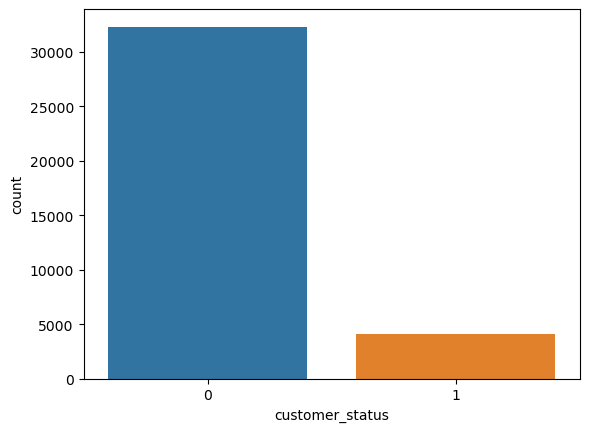

In [28]:
sns.countplot(x='customer_status', data = merged_df)
plt.show()

In [29]:
# Separate the data into labels and features

# Separate the y variable
y = merged_df['customer_status']
display(y.head())


ID
5008804    1
5008805    1
5008806    0
5008808    0
5008809    0
Name: customer_status, dtype: int64

In [30]:
merged_df_dummies = pd.get_dummies(merged_df, columns=['CODE_GENDER','FLAG_OWN_REALTY','FLAG_OWN_CAR','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE'],dtype=int)

merged_df_dummies.head()

customer_status  CNT_CHILDREN  AMT_INCOME_TOTAL  CNT_FAM_MEMBERS  \
ID                                                                          
5008804                1             0          427500.0              2.0   
5008805                1             0          427500.0              2.0   
5008806                0             0          112500.0              2.0   
5008808                0             0          270000.0              1.0   
5008809                0             0          270000.0              1.0   

          AGE  YEARS_EMPLOYED  CODE_GENDER_F  CODE_GENDER_M  \
ID                                                            
5008804  33.0            12.0              0              1   
5008805  33.0            12.0              0              1   
5008806  59.0             3.0              0              1   
5008808  52.0             8.0              1              0   
5008809  52.0             8.0              1              0   

         FLAG_OWN_REALTY_N  FLAG_OWN_REALTY_Y  ...  OCCUPATION_TYPE_Laborers  \
ID                                             ...                             
5008804                  0                  1  ...                         0   
5008805                  0                  1  ...                         0   
5008806                  0                  1  ...                         0   
5008808                  0                  1  ...                         0   
5008809                  0                  1  ...                         0   

         OCCUPATION_TYPE_Low-skill Laborers  OCCUPATION_TYPE_Managers  \
ID                                                                      
5008804                                   0                         1   
5008805                                   0                         1   
5008806                                   0                         0   
5008808                                   0                         0   
5008809                                   0                         0   

         OCCUPATION_TYPE_Medicine staff  \
ID                                        
5008804                               0   
5008805                               0   
5008806                               0   
5008808                               0   
5008809                               0   

         OCCUPATION_TYPE_Private service staff  OCCUPATION_TYPE_Realty agents  \
ID                                                                              
5008804                                      0                              0   
5008805                                      0                              0   
5008806                                      0                              0   
5008808                                      0                              0   
5008809                                      0                              0   

         OCCUPATION_TYPE_Sales staff  OCCUPATION_TYPE_Secretaries  \
ID                                                                  
5008804                            0                            0   
5008805                            0                            0   
5008806                            0                            0   
5008808                            1                            0   
5008809                            1                            0   

         OCCUPATION_TYPE_Security staff  OCCUPATION_TYPE_Waiters/barmen staff  
ID                                                                             
5008804                               0                                     0  
5008805                               0                                     0  
5008806                               1                                     0  
5008808                               0                                     0  
5008809                               0                                     0  

[5 rows x 51 columns]

In [31]:
# Separate the X variable, the features
X = merged_df_dummies.drop(columns=['customer_status'])
X.head()

CNT_CHILDREN  AMT_INCOME_TOTAL  CNT_FAM_MEMBERS   AGE  \
ID                                                               
5008804             0          427500.0              2.0  33.0   
5008805             0          427500.0              2.0  33.0   
5008806             0          112500.0              2.0  59.0   
5008808             0          270000.0              1.0  52.0   
5008809             0          270000.0              1.0  52.0   

         YEARS_EMPLOYED  CODE_GENDER_F  CODE_GENDER_M  FLAG_OWN_REALTY_N  \
ID                                                                         
5008804            12.0              0              1                  0   
5008805            12.0              0              1                  0   
5008806             3.0              0              1                  0   
5008808             8.0              1              0                  0   
5008809             8.0              1              0                  0   

         FLAG_OWN_REALTY_Y  FLAG_OWN_CAR_N  ...  OCCUPATION_TYPE_Laborers  \
ID                                          ...                             
5008804                  1               0  ...                         0   
5008805                  1               0  ...                         0   
5008806                  1               0  ...                         0   
5008808                  1               1  ...                         0   
5008809                  1               1  ...                         0   

         OCCUPATION_TYPE_Low-skill Laborers  OCCUPATION_TYPE_Managers  \
ID                                                                      
5008804                                   0                         1   
5008805                                   0                         1   
5008806                                   0                         0   
5008808                                   0                         0   
5008809                                   0                         0   

         OCCUPATION_TYPE_Medicine staff  \
ID                                        
5008804                               0   
5008805                               0   
5008806                               0   
5008808                               0   
5008809                               0   

         OCCUPATION_TYPE_Private service staff  OCCUPATION_TYPE_Realty agents  \
ID                                                                              
5008804                                      0                              0   
5008805                                      0                              0   
5008806                                      0                              0   
5008808                                      0                              0   
5008809                                      0                              0   

         OCCUPATION_TYPE_Sales staff  OCCUPATION_TYPE_Secretaries  \
ID                                                                  
5008804                            0                            0   
5008805                            0                            0   
5008806                            0                            0   
5008808                            1                            0   
5008809                            1                            0   

         OCCUPATION_TYPE_Security staff  OCCUPATION_TYPE_Waiters/barmen staff  
ID                                                                             
5008804                               0                                     0  
5008805                               0                                     0  
5008806                               1                                     0  
5008808                               0                                     0  
5008809                               0                                     0  

[5 rows x 50 columns]

In [32]:
# Check the balance of our target values
y.value_counts()

customer_status
0    32308
1     4149
Name: count, dtype: int64

In [33]:
# Import the train_test_learn module
from sklearn.model_selection import train_test_split

# Split the data using train_test_split
# Assign a random_state of 1 to the function
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [34]:
# Standardize the feature using StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
# Instantiate the Logistic Regression model
# Assign a random_state parameter of 42 to the models

logistic_regression_model = LogisticRegression(random_state=1)

# Fit the model using training data
logistic_regression_model.fit(X_train_scaled,y_train)

LogisticRegression(random_state=1)

In [36]:
# Make a prediction using the testing data
testing_predictions = logistic_regression_model.predict(X_test_scaled)
print(len(testing_predictions))

9115


In [37]:
# Print the balanced_accuracy score of the model

logistic_acc_score = balanced_accuracy_score(y_test, testing_predictions)
print(logistic_acc_score)

0.5


In [38]:
# Generate a confusion matrix for the model

confusion_test_matrix = confusion_matrix(y_test, testing_predictions)
confusion_test_matrix

array([[8063,    0],
       [1052,    0]])

In [39]:
# Print the classification report for the model
testing_report = classification_report(y_test, testing_predictions)
print(testing_report)

              precision    recall  f1-score   support

           0       0.88      1.00      0.94      8063
           1       0.00      0.00      0.00      1052

    accuracy                           0.88      9115
   macro avg       0.44      0.50      0.47      9115
weighted avg       0.78      0.88      0.83      9115



/Users/kobe/anaconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kobe/anaconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kobe/anaconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Text(0.5, 1.0, 'Confustion Matrix')

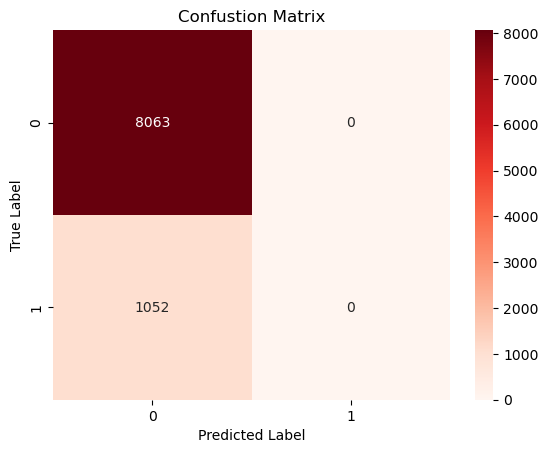

In [40]:
# Plot confusion matrix heatmap
#plt.figure(figsize=(8,6))
sns.heatmap(confusion_test_matrix,cmap='Reds',annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confustion Matrix')


In [41]:
# Import the RandomOverSampler module form imbalanced-learn
from imblearn.over_sampling import RandomOverSampler

# Instantiate the random oversampler model
# # Assign a random_state parameter of 1 to the model
random_oversampler_model = RandomOverSampler(random_state=1)

# Fit the original training data to the random_oversampler model
X_res, y_res =random_oversampler_model.fit_resample(X_train, y_train)

In [42]:
# Count the distinct values of the resampled lables data.random_oversampler_model
y_res.value_counts()

customer_status
0    24245
1    24245
Name: count, dtype: int64

In [43]:
# Standardize the feature using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_res)
X_test_scaled = scaler.fit_transform(X_test)

In [44]:
# Instantiate the Logistic Regression model
logistic_regression_model_resampled = LogisticRegression(random_state=1)
logistic_regression_model_resampled

# Fit the model using the resampled training data
logistic_regression_model_resampled.fit(X_train_scaled, y_res)

# Make a prediction using the testing data
y_pred = logistic_regression_model_resampled.predict(X_test_scaled)

In [45]:
# Print the balanced_accuracy score of the model 
balanced_accuracy_score(y_test, y_pred)

0.5364444047800379

In [46]:
# Generate a confusion matrix for the model
confusion_matrix_resampled = confusion_matrix(y_test, y_pred)
print(confusion_matrix_resampled)

[[4167 3896]
 [ 467  585]]


In [47]:
classification_report_resampled = classification_report_imbalanced(y_test, y_pred)
print(classification_report_resampled)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.90      0.52      0.56      0.66      0.54      0.29      8063
          1       0.13      0.56      0.52      0.21      0.54      0.29      1052

avg / total       0.81      0.52      0.55      0.61      0.54      0.29      9115



Text(0.5, 1.0, 'Confustion Matrix Resampled')

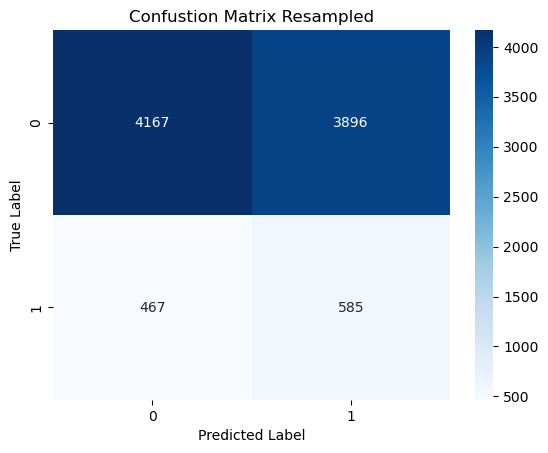

In [48]:
# Plot confusion matrix resampled heatmap

sns.heatmap(confusion_matrix_resampled,cmap='Blues',annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confustion Matrix Resampled')

In [49]:
# Creating StandardScaler instance
scaler = StandardScaler()

# Fitting Standard Scaler
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [50]:
# Creating the decision tree classifier instance
model = tree.DecisionTreeClassifier()

# Fitting the model
model = model.fit(X_train_scaled, y_train)

In [51]:
# Making predictions using the testing data
predictions = model.predict(X_test_scaled)

In [52]:
# Displaying classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      8063
           1       0.49      0.32      0.39      1052

    accuracy                           0.88      9115
   macro avg       0.70      0.64      0.66      9115
weighted avg       0.87      0.88      0.87      9115



dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.187867 to fit



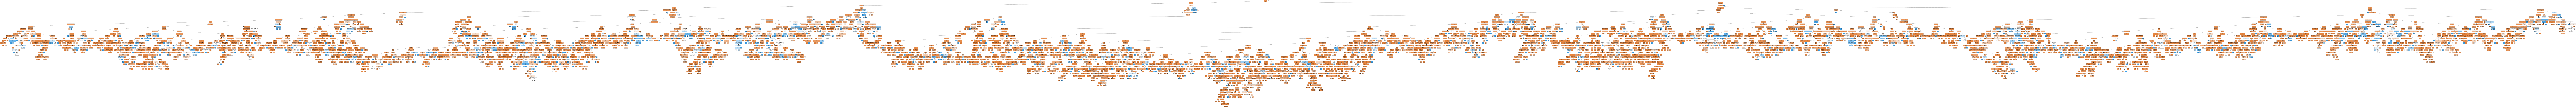

In [53]:
# Create DOT data
dot_data = tree.export_graphviz(model, out_file=None, feature_names=X_train.columns, class_names=["0","1"], filled= True)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)

# Show graph
Image(graph.create_png())